/Users/nehabharti/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/nehabharti/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


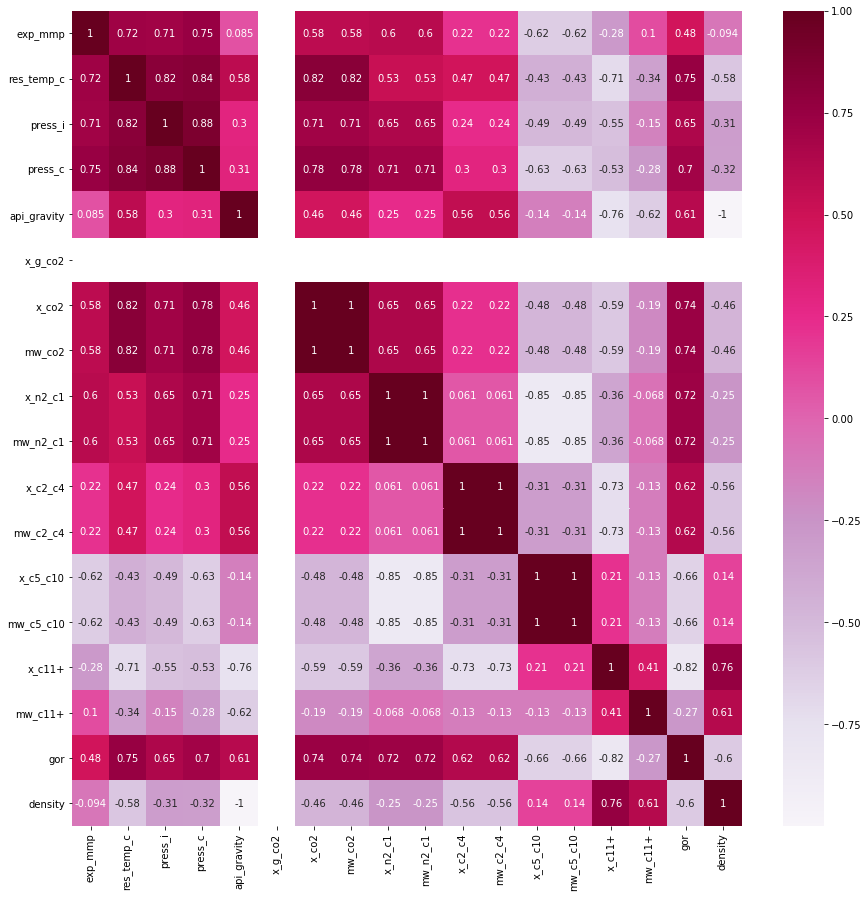

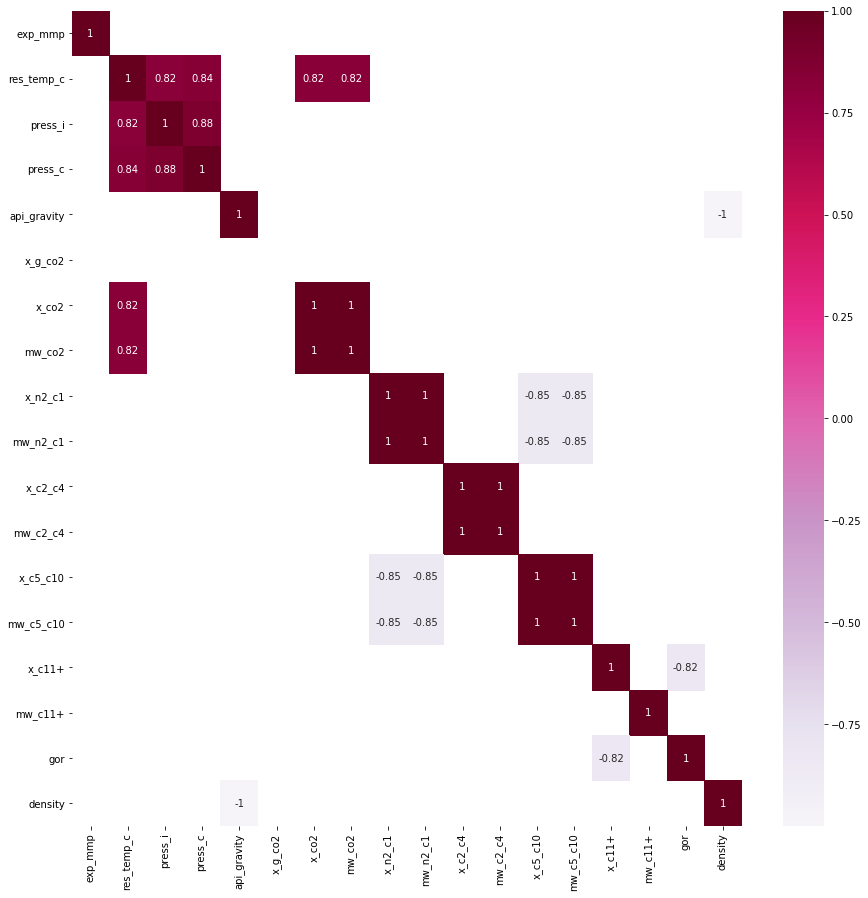

In [1]:
#importing required modules
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pickle
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
%matplotlib inline
from sklearn.model_selection import train_test_split

#importing excel sheet
mmp_df = pd.read_excel(r"~/EOR PREDICTOR/mmp data.xlsx")

#changing index
mmp_df = mmp_df.set_index("Sand")

#dropping irrelevant feautures
mmp_df = mmp_df.drop(["MMP (theoretical)", "Samplig Pressure(Kg/cm2)", "Sampling type ","Viscosity (CP)", \
            "total mole%", "total molecular wt", "Depth (m)", "Field"], axis=1)

columns_name = {"MMP(kg/cm2) (exp) (FCM/MCM)":"exp_mmp", "Reservoir Temperature C":"res_temp_c",\
                "Depth (m)":"depth_m", "Initial Reservoir Pressure (Kg/cm2)":"press_i",\
                "Current Reservoir Pressure (Kg/cm2)": "press_c","API":"api_gravity",\
               "Injectant Gas composition CO2(%)":"x_g_co2", "%mole of CO2":'x_co2',
                'mol wt contribution of CO2':'mw_co2', r'%mole of N2+C1': 'x_n2_c1',
                r'mol wt contribution of N2+C1':'mw_n2_c1', r'%mole of C2-C4':'x_c2_c4',
                r'mol wt contribution of C2-C4':'mw_c2_c4', r'%mole of C5-C10':'x_c5_c10',
                'mol wt contribution of C5-C10':'mw_c5_c10', r'% mole of C11+':'x_c11+',
                'mol wt contribution of C11+':'mw_c11+', 'GOR':'gor',
                r'Density of well stream at 0 psig and 60 degree F':'density'}

mmp_df = mmp_df.rename(columns=columns_name)


mmp_df = mmp_df.astype(float)


corr = mmp_df.corr()

#correlation heat map
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, cmap="PuRd")

corr1 = corr[(corr>0.8) + (corr<-0.8)]
plt.figure(figsize=(15,15))
sns.heatmap(corr1, annot=True, cmap="PuRd")
mmp_df_before = mmp_df

#variance calculation and redundant parameters dropped
X1 = sm.tools.add_constant(mmp_df_before)
series_before = pd.Series ([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])],index= X1.columns)

mmp_df_after  = mmp_df[["exp_mmp", "res_temp_c"]]

X2 = sm.tools.add_constant(mmp_df_after)
series_after = pd.Series ([variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])], index = X2.columns)
series_after

mmp_df_after.describe()

#Building the model

X = mmp_df_after.drop("exp_mmp", axis=1)
Y = mmp_df_after[["exp_mmp"]]

#training and splittiing the data

X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.2, random_state = 1)
regression_model = LinearRegression ()
regression_model.fit(X_train, Y_train)
intercept = regression_model.intercept_[0]
coeff = regression_model.coef_[0,0]
Y_predict = regression_model.predict(X_test)


with open ("mmp_predictor.sav", "wb") as f:
    pickle.dump(regression_model, f)

with open ("mmp_predictor.sav", "rb") as pickle_file:
    regression_model_2 = pickle.load (pickle_file)
    
T = float(input ("enter reservoir temperature in deg C "))
print("The MMP of reservoir at %f deg C is %f" %(T, regression_model_2.predict([[T]])))